In [4]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression

In [3]:
auto = pd.read_csv('Auto.csv')

In [5]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Problem 8

In [28]:
# Remove these data points
print(np.where(auto['horsepower'] == '?'))

(array([ 32, 126, 330, 336, 354]),)

In [96]:
X = auto.iloc[~auto.index.isin([32, 126, 330, 336, 354]), :]['horsepower'].astype(float).values.reshape(-1, 1)
y = auto.iloc[~auto.index.isin([32, 126, 330, 336, 354]), :]['mpg'].astype(float).values.reshape(-1, 1)
linreg = LinearRegression().fit(X, y)

Ok, first reproduce the output from R's `summary()`.

```
Call:
lm(formula = mpg ~ horsepower, data = auto)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.5710  -3.2592  -0.3435   2.7630  16.9240 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 39.935861   0.717499   55.66   <2e-16 ***
horsepower  -0.157845   0.006446  -24.49   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.906 on 390 degrees of freedom
Multiple R-squared:  0.6059,	Adjusted R-squared:  0.6049 
F-statistic: 599.7 on 1 and 390 DF,  p-value: < 2.2e-16
```

`sklearn` doesn't provide all of this information. The tricky part is figuring out the standard error. In the univariate case, equation (3.8) gives us 

\begin{align}
SE(\hat{\beta}_0)^2 &= \hat{\sigma}^2 \left( \frac{1}{n} + \frac{\bar{x}^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2} \right) \\
SE(\hat{\beta}_1)^2 &= \frac{\hat{\sigma}^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
\end{align}

Below, the summation is given by `dev`.

The true value of $\sigma^2 = Var(\epsilon)$ is not known, but can be estimated from the data. $\hat{\sigma}$ is known as residual standard error (`rse`). Each $\beta_i$ is a Gaussian random variable, the fitted coefficient $\hat{\beta_i}$ is the mean of the Gaussian distribution, and the standard error is the square root of the distribution's variance.

In [188]:
rse

4.90575691954594

In [269]:
y_hat = linreg.predict(X)
residuals = y - y_hat
tss = np.sum((y - np.mean(y)) ** 2)
rss = np.sum((y_hat - y) ** 2)
mse = rss / len(X)
sxx = np.sum((X - np.mean(X)) ** 2)
rse = math.sqrt(rss / (len(X) - 2))
beta0_se = rse * math.sqrt(1 / len(X) + np.mean(X) ** 2 / sxx)
beta1_se = rse / math.sqrt(sxx)
beta0_t = linreg.intercept_[0] / beta0_se
beta1_t = linreg.coef_[0][0] / beta1_se

The t statistic assumes $H_0$ where $X$ and $y$ have no relationship, with $n - 2$ degrees of freedom.

In [217]:
from scipy.stats import t, f
beta0_pr = t.pdf(beta0_t, len(X) - 2)
beta1_pr = t.pdf(beta1_t, len(X) - 2)
model_f = (tss - rss) / (rss / (len(X) - 1 - 1))
model_f_pval = f.pdf(model_f, len(X), 1)

In [218]:
print('Residuals:\nMin: {:.4f}, 1Q: {:.4f}, Median: {:.4f}, 3Q: {:.4f}, Max: {:.4f}\n'.format(
    np.min(residuals),
    np.quantile(residuals, 0.25),
    np.median(residuals),
    np.quantile(residuals, 0.75),
    np.max(residuals)))
print('Coefficients: Estimate, stderror, t-value, Pr(>|t|)')
print('(Intercept): {:.4f}, {:.4f}, {:.4f}, {:.2e}'.format(linreg.intercept_[0], beta0_se, beta0_t, beta0_pr))
print('horsepower: {:.4f}, {:.4f}, {:.4f}, {:.2e}'.format(linreg.coef_[0][0], beta1_se, beta1_t, beta1_pr))

print('\nRSE: {:.4f}, R2: {:.4f}, F: {:.4f}, p-value: {:.4f}'.format(rse, 1 - rss / tss, model_f, model_f_pval))

Residuals:
Min: -13.5710, 1Q: -3.2592, Median: -0.3435, 3Q: 2.7630, Max: 16.9240

Coefficients: Estimate, stderror, t-value, Pr(>|t|)
(Intercept): 39.9359, 0.7175, 55.6598, 3.80e-187
horsepower: -0.1578, 0.0064, -24.4891, 3.40e-80

RSE: 4.9058, R2: 0.6059, F: 599.7177, p-value: 0.0000


In [268]:
# iv
y_pred = linreg.predict([[98]])[0][0]
t_mag = t.ppf(0.975, len(X) - 2)
print('Predicted mpg: {:.4f}'.format(y_pred))
# print('Confidence interval: [{:.4f}, {:.4f}]'.format(y_pred - t_mag * beta0_se, y_pred + beta1_se * 2.1))

Predicted mpg: 24.4671


In [223]:
t.pdf(x, 390) = 0.95

0.2537352299471792

In [237]:
np.min(auto.mpg)

9.0

### 8b

<IPython.core.display.Javascript object>


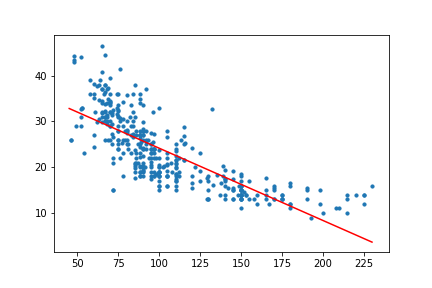

In [295]:
X_sample = np.linspace(45, 230, len(X)).reshape(-1, 1)
y_sample = linreg.predict(X_sample)
plt.figure()
plt.plot(X_sample, y_sample, 'r-')
plt.scatter(X, y, s = 10)
plt.show()

### 8c

In R, the `plot()` function for fitted models displays a few plots. Here they are reproduced with some changes.

- **Residuals vs Fitted**: This does not include the LOWESS regression line.
- **Normal Q-Q**: Not sure what "Theoretical quantiles" refers to.
- **Scale-Location**: Does not include LOWESS regression line.
- **Residuals vs Leverage**: Does not include Cook's distance line, which involves fitting many, many models.

<IPython.core.display.Javascript object>


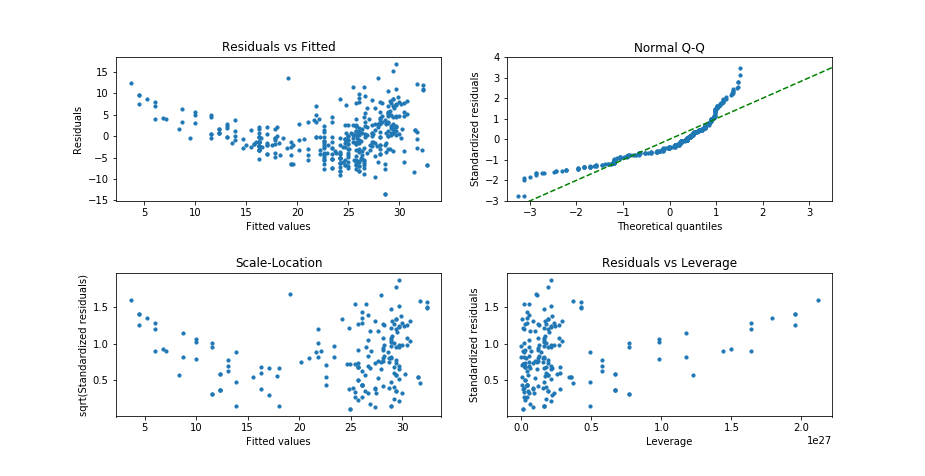

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


In [325]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
fig.subplots_adjust(hspace = .5)
resfit, qq, scaleloc, reslev = axes.flatten()

# residuals vs fitted
resfit.scatter(y_hat, residuals, s = 10)
resfit.set_xlabel('Fitted values', fontsize=10)
resfit.set_ylabel('Residuals', fontsize=10)
resfit.set_title('Residuals vs Fitted', fontsize = 12)

# q-q
qq.scatter(np.sort(y_hat - np.mean(y_hat), axis = 0) / np.std(y_hat), np.sort(residuals / np.std(residuals), axis = 0), s = 10)
# qq.scatter(np.sort(residuals / len(residuals), axis = 0), np.sort(residuals / np.std(residuals), axis = 0), s = 10)
qq.plot([-3.5, 3.5], [-3.5, 3.5], 'g--')
qq.set_xlim(-3.5, 3.5)
qq.set_ylim(-3, 4)
qq.set_xlabel('Theoretical quantiles', fontsize=10)
qq.set_ylabel('Standardized residuals', fontsize=10)
qq.set_title('Normal Q-Q', fontsize = 12)

# scale-location
scaleloc.scatter(y_hat, np.sqrt(residuals / np.std(residuals)), s = 10)
scaleloc.set_xlabel('Fitted values', fontsize = 10)
scaleloc.set_ylabel('sqrt(Standardized residuals)', fontsize = 10)
scaleloc.set_title('Scale-Location', fontsize = 12)

# residuals vs leverage
leverage = 1 / len(X) + (X - np.mean(X)) ** 2 / np.sum(X - np.mean(X)) ** 2
reslev.scatter(leverage, np.sqrt(residuals / np.std(residuals)), s = 10)
reslev.set_xlabel('Leverage', fontsize = 10)
reslev.set_ylabel('Standardized residuals', fontsize = 10)
reslev.set_title('Residuals vs Leverage', fontsize = 12)

fig.show()

## Problem 9

### 9a

<IPython.core.display.Javascript object>


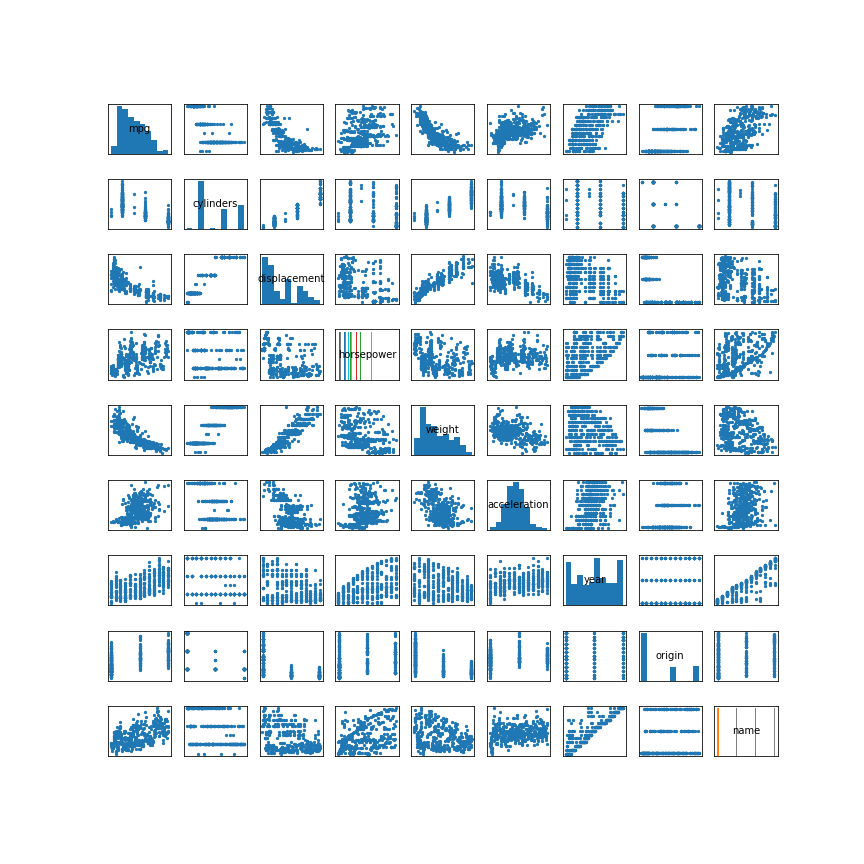

In [349]:
fig, axes = plt.subplots(nrows = 9, ncols = 9, figsize = (12, 12))
fig.subplots_adjust(hspace = .5)

for col, facets in enumerate(axes):
    for row, facet in enumerate(facets):
        if row == col:
            facet.annotate(auto.columns[row], (0.5, 0.5), ha = 'center', va = 'center', xycoords = 'axes fraction')
            facet.hist(auto.iloc[:, row])
        else:
            facet.scatter(auto.iloc[:, col], auto.iloc[:, row], s = 5)

        facet.xaxis.set_visible(False)
        facet.yaxis.set_visible(False)

### 9b

In [367]:
corr_matrix = pd.DataFrame(np.corrcoef(auto.drop('name', axis = 1).apply(pd.to_numeric, errors='coerce').dropna().T))
corr_matrix.index = auto.columns[:-1]
corr_matrix.columns = auto.columns[:-1]
corr_matrix

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


### 9c

In [53]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [60]:
X = auto.drop(['name', 'mpg'], axis = 1).apply(pd.to_numeric, errors = 'coerce')
auto_colnames = X.columns
y = auto['mpg'][~X.isnull().any(axis = 1)]
X = X.dropna().values

Let's reproduce this summary table from R's `summary()`:

```
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -17.218435   4.644294  -3.707  0.00024 ***
cylinders     -0.493376   0.323282  -1.526  0.12780    
displacement   0.019896   0.007515   2.647  0.00844 ** 
horsepower    -0.016951   0.013787  -1.230  0.21963    
weight        -0.006474   0.000652  -9.929  < 2e-16 ***
acceleration   0.080576   0.098845   0.815  0.41548    
year           0.750773   0.050973  14.729  < 2e-16 ***
origin         1.426141   0.278136   5.127 4.67e-07 ***
```

In [104]:
linreg = LinearRegression().fit(X, y)

The standard error is derived from the diagonal of the variance-covariance matrix of these coefficients, $\text{Var}(\hat{\beta})$ (ESL 3.8):

\begin{align}
\text{Var}(\hat{\beta}) &= \left(\textbf{X}^T\textbf{X}\right)^{-1} \sigma^2
\end{align}

The variance is estimated as in the simple linear regression, except with $p = 7$:

\begin{align}
\hat{\sigma}^2 = \frac{1}{N - p - 1} \sum_{i = 1}^{N}(y_i - \hat{y}_i)^2
\end{align}

In [151]:
rss = np.sum((y - linreg.predict(X)) ** 2)
var_hat = rss / (len(X) - 7 - 1)
betahat_covmat = np.matrix(np.matmul(X.T, X)).I * var_hat
betahat_se = np.sqrt(betahat_covmat.diagonal())

In [ ]:
summary.columns

In [162]:
summary.columns

Index([0, 'se'], dtype='object')

In [172]:
model_f

252.42804529131897

In [179]:
from scipy.stats import t, f
summary = pd.DataFrame(np.append(linreg.intercept_, linreg.coef_))
summary.index = np.append('(intercept)', auto_colnames)
summary['se'] = np.append(0, betahat_se)
summary['t'] = np.append(0, linreg.coef_ / betahat_se)
summary['p'] = t.pdf(summary['t'], len(X) - 7 - 1)

# F-test
tss = np.sum((y - np.mean(y)) ** 2)
model_f = ((tss - rss) / 7) / (rss / (len(X) - 7 - 1))

print('F-statistic: {:4f}, {:4f}'.format(model_f, f.pdf(model_f, len(X), 7)))
summary


F-statistic: 252.428045, 0.000000


,0,se,t,p
(intercept),-17.218435,0.000000,0.000000,3.986826e-01
cylinders,-0.493376,0.318180,-1.550622,1.198904e-01
displacement,0.019896,0.007496,2.654130,1.204671e-02
horsepower,-0.016951,0.012365,-1.370861,1.557709e-01
weight,-0.006474,0.000641,-10.098848,8.113109e-21
acceleration,0.080576,0.088901,0.906356,2.642235e-01
year,0.750773,0.023776,31.577005,3.895953e-108
origin,1.426140,0.276365,5.160353,9.892067e-07


### 9d

In [181]:
y_hat = linreg.predict(X)
residuals = y - y_hat

<IPython.core.display.Javascript object>


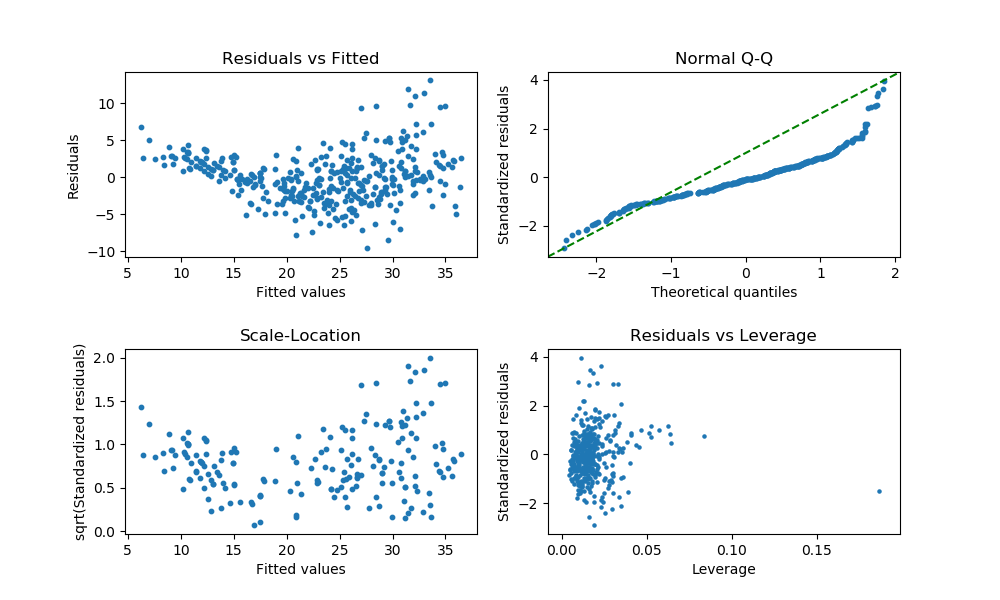

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


In [219]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
fig.subplots_adjust(hspace = .5)
resfit, qq, scaleloc, reslev = axes.flatten()

# residuals vs fitted
resfit.scatter(y_hat, residuals, s = 10)
resfit.set_xlabel('Fitted values', fontsize=10)
resfit.set_ylabel('Residuals', fontsize=10)
resfit.set_title('Residuals vs Fitted', fontsize = 12)

# q-q
# again, this is wrong - see https://stackoverflow.com/questions/37897274/plot-lm-extracting-numbers-labelled-in-the-diagnostic-q-q-plot for correct solution to generating q-q
qq.scatter(np.sort(y_hat - np.mean(y_hat), axis = 0) / np.std(y_hat), np.sort((residuals - np.mean(residuals)) / np.std(residuals), axis = 0), s = 10)
qq.plot([0, 1], [0, 1], 'g--', transform = qq.transAxes)
qq.set_xlabel('Theoretical quantiles', fontsize=10)
qq.set_ylabel('Standardized residuals', fontsize=10)
qq.set_title('Normal Q-Q', fontsize = 12)

# scale-location
scaleloc.scatter(y_hat, np.sqrt((residuals - np.mean(residuals)) / np.std(residuals)), s = 10)
scaleloc.set_xlabel('Fitted values', fontsize = 10)
scaleloc.set_ylabel('sqrt(Standardized residuals)', fontsize = 10)
scaleloc.set_title('Scale-Location', fontsize = 12)

# residuals vs leverage
# multiple linear regression version: leverage = diagonals of X(X^T X)-1 XT
leverage = np.array(np.matmul(np.matmul(X, np.matrix(np.matmul(X.T, X)).I), X.T).diagonal())[0]
reslev.scatter(leverage, (residuals - np.mean(residuals)) / np.std(residuals), s = 5)
reslev.set_xlabel('Leverage', fontsize = 10)
reslev.set_ylabel('Standardized residuals', fontsize = 10)
reslev.set_title('Residuals vs Leverage', fontsize = 12)

fig.show()

### 9e

In [220]:
auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

In [ ]:
X
linreg = LinearRegression().fit(X, y)